In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statistics
import yfinance as yf

# just run the whole notebook, stocks_final the tickers of the selected stock

In [2]:
# get all the tickers on nasdaq
# https://github.com/shilewenuw/get_all_tickers/issues/12
import requests
import pandas as pd

headers = {
    'authority': 'api.nasdaq.com',
    'accept': 'application/json, text/plain, */*',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36',
    'origin': 'https://www.nasdaq.com',
    'sec-fetch-site': 'same-site',
    'sec-fetch-mode': 'cors',
    'sec-fetch-dest': 'empty',
    'referer': 'https://www.nasdaq.com/',
    'accept-language': 'en-US,en;q=0.9',
}

params = (
    ('tableonly', 'true'),
    ('limit', '25'),
    ('offset', '0'),
    ('download', 'true'),
)

r = requests.get('https://api.nasdaq.com/api/screener/stocks', headers=headers, params=params)
data = r.json()['data']
stocks = pd.DataFrame(data['rows'], columns=data['headers']) 
stocks['volume'] = pd.to_numeric(stocks['volume'], errors='coerce')
symbols = stocks.sort_values('volume', ascending=False)['symbol'] # sort symbols by volume traded

In [3]:
stocks.sort_values('volume',ascending=False).head(500)

,symbol,name,lastsale,netchange,pctchange,marketCap,country,ipoyear,volume,sector,industry,url
5837,SLNA,Selina Hospitality PLC Ordinary Shares,$0.03,-0.0076,-20.213%,16310069.00,United Kingdom,,397736455,Consumer Discretionary,Hotels/Resorts,/market-activity/stocks/slna
816,BFI,BurgerFi International Inc. Common Stock,$0.4205,0.2074,97.325%,11523192.00,Mexico,2018,313305863,Consumer Discretionary,Restaurants,/market-activity/stocks/bfi
4584,NVDA,NVIDIA Corporation Common Stock,$113.06,0.78,0.695%,2781088543128.00,United States,1999,292800749,Technology,Semiconductors,/market-activity/stocks/nvda
5738,SGMO,Sangamo Therapeutics Inc. Common Stock,$0.8649,0.1929,28.705%,179475465.00,United States,2000,123510652,Health Care,Biotechnology: Biological Products (No Diagnos...,/market-activity/stocks/sgmo
6218,TELL,Tellurian Inc. Common Stock,$0.9202,-0.0228,-2.418%,769495836.00,United States,,102132011,Energy,Oil & Gas Production,/market-activity/stocks/tell
...,...,...,...,...,...,...,...,...,...,...,...,...
5694,SEDG,SolarEdge Technologies Inc. Common Stock,$27.57,0.12,0.437%,1579744568.00,Israel,2015,3134374,Technology,Semiconductors,/market-activity/stocks/sedg
6149,TAL,TAL Education Group American Depositary Shares,$10.74,0.34,3.269%,6503692899.00,China,,3125369,Real Estate,Other Consumer Services,/market-activity/stocks/tal
4405,NFLX,Netflix Inc. Common Stock,$631.37,-2.72,-0.429%,270961662973.00,United States,2002,3118849,Consumer Discretionary,Consumer Electronics/Video Chains,/market-activity/stocks/nflx
6322,TMUS,T-Mobile US Inc. Common Stock,$175.53,0.39,0.223%,205695578082.00,United States,,3116934,Telecommunications,Telecommunications Equipment,/market-activity/stocks/tmus


In [4]:
start_date = "2023-01-01"
end_date = "2024-01-01"
df = yf.download(list(symbols)[:500],start=start_date, end=end_date)
df.dropna(axis=1, inplace=True)

[*********************100%%**********************]  500 of 500 completed

8 Failed downloads:
['ETHA', 'CORZ', 'LINE', 'SW', 'SERV', 'VHAI', 'GEV', 'ZPTA']: Exception("%ticker%: Data doesn't exist for startDate = 1672549200, endDate = 1704085200")


In [5]:
corr_matrix = df['Adj Close'].corr()

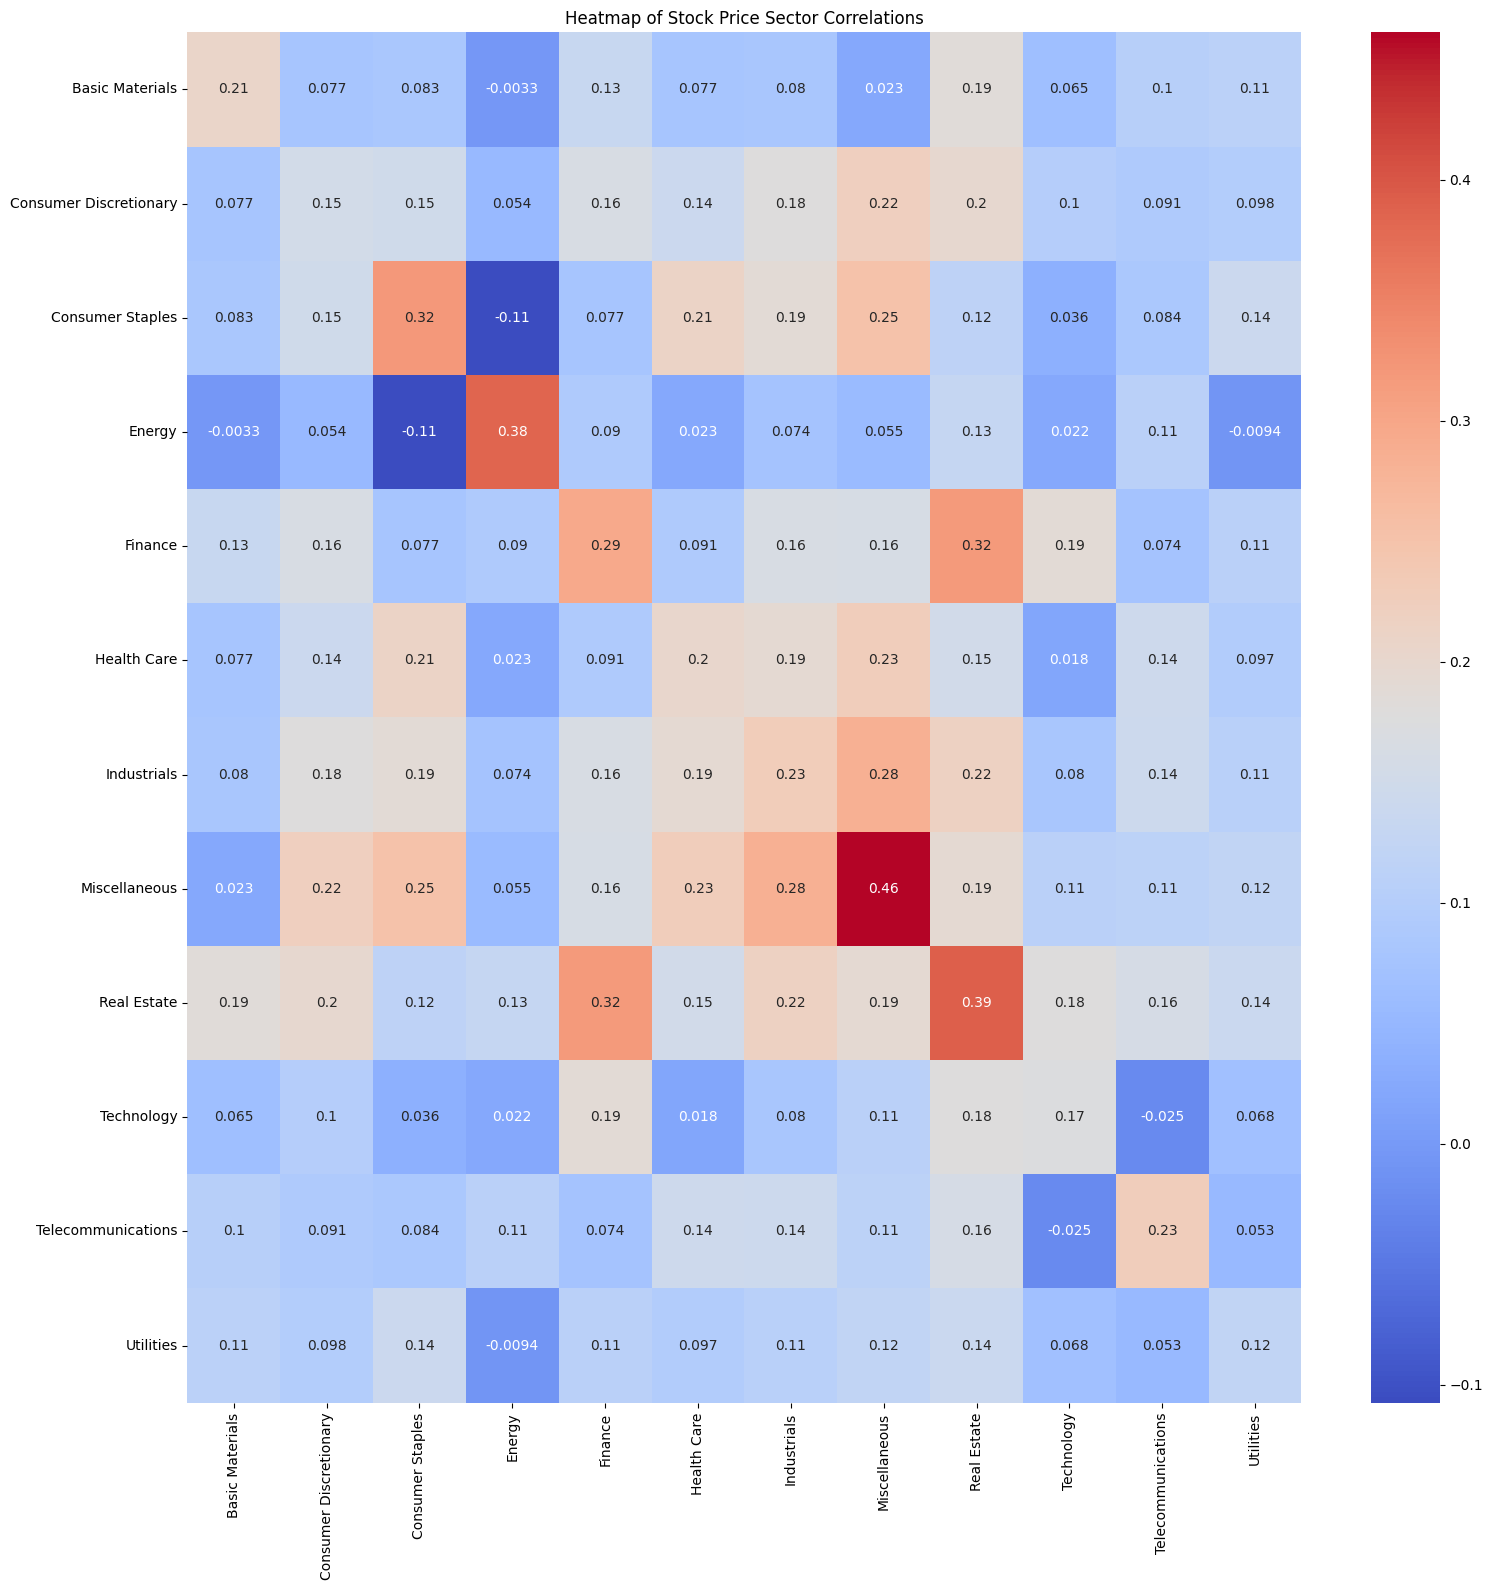

In [6]:
def nasdaq_sector_mapping():
    ticker_meta = stocks[[
        "symbol",
        "sector"
    ]].to_dict(orient='records')

    mapping_dict = {}
    for ticker in ticker_meta:
        mapping_dict[ticker["symbol"]] = ticker["sector"]

    return mapping_dict

sector_mapping = nasdaq_sector_mapping()
mapped_sectors = corr_matrix.columns.map(sector_mapping)
mean_corr_by_sector = (
    corr_matrix.groupby(mapped_sectors).mean().groupby(mapped_sectors, axis=1).mean()
)

plt.figure(figsize=(16, 16))
sns.heatmap(mean_corr_by_sector, annot=True, cmap="coolwarm")
plt.title("Heatmap of Stock Price Sector Correlations")
# plt.savefig("heatmap_sector.png")
plt.tight_layout()
plt.show()

In [7]:
# compute volatility using Pandas rolling and std methods, the trading days is set to 252 days
YEAE_DAYS = 252
PERIOD_DAYS = df.shape[0]
returns = np.log(df['Adj Close']/df['Adj Close'].shift(1))
returns.fillna(0, inplace=True)
volatility = returns.rolling(window=PERIOD_DAYS).std()*np.sqrt(YEAE_DAYS)
volatility.tail(1)

,AA,AAL,AAPL,ABBV,ABEV,ABNB,ABT,ACHR,ADI,ADT,...,WY,XEL,XOM,XP,XPEV,XPRO,XRX,YMM,ZI,ZIM
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29,0.518512,0.351989,0.19883,0.197113,0.246245,0.421608,0.19728,0.905404,0.261256,0.420525,...,0.237156,0.196794,0.248103,0.520718,0.785841,0.47009,0.362431,0.505943,0.587725,0.646311


Text(0.5, 0, 'volatility')

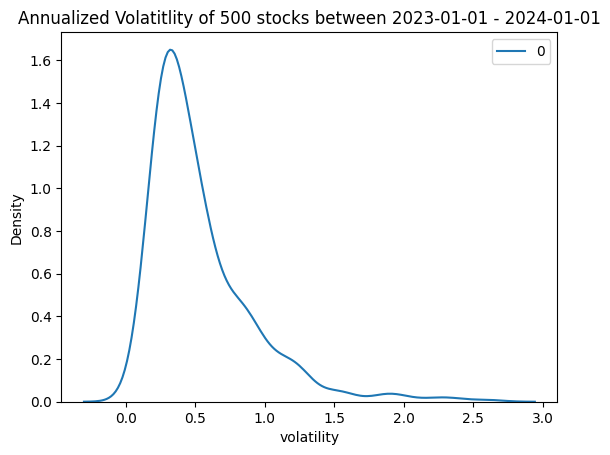

In [8]:
ax = sns.kdeplot(np.array(volatility.tail(1)).reshape(-1, 1), label='Density')
ax.set_title(f'Annualized Volatitlity of 500 stocks between {start_date} - {end_date}')
ax.set_xlabel('volatility')

In [10]:
hist_vol = volatility.tail(1).transpose().reset_index().rename(columns={"index": "symbol", volatility.index[-1]: "volatility"})
# hist_vol.indexrename = ['index']

In [11]:
hist_vol.describe()

Date,volatility
count,481.000000
mean,0.537856
std,0.379453
min,0.028967
25%,0.284105
50%,0.422858
75%,0.659572
max,2.611501


In [12]:
hist_vol.loc[hist_vol['volatility'] < 0.66].loc[hist_vol['volatility'] > 0.41]

Date,symbol,volatility
0,AA,0.518512
5,ABNB,0.421608
9,ADT,0.420525
10,AEO,0.442729
13,AG,0.559929
...,...,...
474,XP,0.520718
476,XPRO,0.470090
478,YMM,0.505943
479,ZI,0.587725


In [13]:
symbols_filter_by_vol = hist_vol.loc[hist_vol['volatility'] < 0.66].loc[hist_vol['volatility'] > 0.41]

In [14]:
symbols_filter_by_vol

Date,symbol,volatility
0,AA,0.518512
5,ABNB,0.421608
9,ADT,0.420525
10,AEO,0.442729
13,AG,0.559929
...,...,...
474,XP,0.520718
476,XPRO,0.470090
478,YMM,0.505943
479,ZI,0.587725


In [15]:
ten_year_treasury = yf.download("^TNX",start=start_date, end=end_date)
risk_free_rate = ten_year_treasury['Adj Close'].mean()/100

[*********************100%%**********************]  1 of 1 completed


In [16]:
YEAE_DAYS = len(df)
PERIOD_DAYS = df.shape[0]
# returns = np.log(df['Adj Close']/df['Adj Close'].shift(1))
returns = df['Adj Close'].pct_change()
returns.fillna(0, inplace=True)
# volatility = returns.rolling(window=PERIOD_DAYS).std()*np.sqrt(YEAE_DAYS)
# sharpe_ratio = (returns.rolling(window=PERIOD_DAYS).mean()*YEAE_DAYS - risk_free_rate) / volatility
volatility = returns.std()*np.sqrt(YEAE_DAYS)
sharpe_ratio = (returns.mean()*YEAE_DAYS - risk_free_rate) / volatility
sharpe_ratio

AA     -0.319754
AAL     0.277018
AAPL    2.103493
ABBV   -0.141810
ABEV    0.488330
          ...   
XPRO    0.001132
XRX     0.779017
YMM    -0.268299
ZI     -0.608343
ZIM    -0.085891
Length: 481, dtype: float64

In [17]:
sharpe_ratio_df = pd.DataFrame({
    'symbol' : list(df.columns.get_level_values(1).unique()),
    'Sharpe Ratio': np.array(sharpe_ratio)
})

Text(0.5, 0, 'Sharpe Ratio')

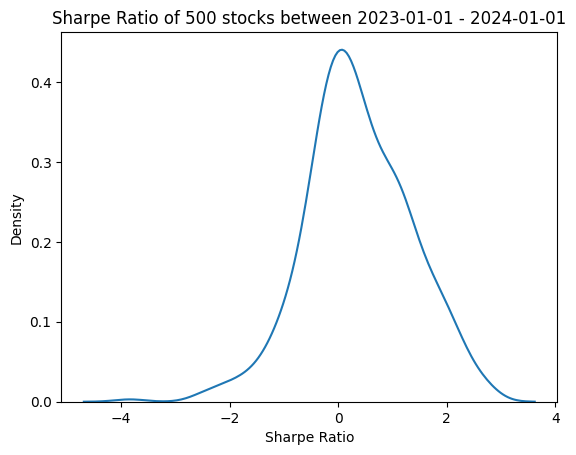

In [18]:
ax = sns.kdeplot(sharpe_ratio_df['Sharpe Ratio'], label='Density')
ax.set_title(f'Sharpe Ratio of 500 stocks between {start_date} - {end_date}')
ax.set_xlabel('Sharpe Ratio')

In [19]:
sharpe_ratio_df.describe()

,Sharpe Ratio
count,481.000000
mean,0.365843
std,0.974697
min,-3.836879
25%,-0.241403
50%,0.278058
75%,1.054446
max,2.770481


In [20]:
symbols_filter_by_sharpe = sharpe_ratio_df.loc[sharpe_ratio_df['Sharpe Ratio'] > 1.14]

In [21]:
symbol_filter_by_vol_sharpe = list(set(symbols_filter_by_vol['symbol']).intersection(symbols_filter_by_sharpe['symbol']))

In [22]:
df2 = yf.download(symbol_filter_by_vol_sharpe,start=start_date, end=end_date)

[*********************100%%**********************]  26 of 26 completed


In [23]:
tickers = symbol_filter_by_vol_sharpe
sma_short = df2['Adj Close'].rolling(window=5).mean()
sma_long = df2['Adj Close'].rolling(window=10).mean()

def screen_by_sma(data, sma_short, sma_long):
    selected_stocks = []
    for ticker in tickers:
        if (sma_short[ticker][-1] > sma_long[ticker][-1] and  # Current SMA crossover criterion
            (sma_short[ticker] > sma_long[ticker]).sum() > len(sma_short[ticker]) // 2):  # Historical trend criterion
            selected_stocks.append(ticker)
    return selected_stocks

selected_stocks = screen_by_sma(df2, sma_short, sma_long)
print("Selected Stocks:", selected_stocks)

Selected Stocks: ['STNE', 'CCL', 'SOFI', 'AMD', 'GPS', 'PR', 'SHOP', 'TSLA', 'NAT', 'NVDA', 'XP', 'DKNG', 'NXE', 'UEC', 'VRT', 'RKT']


In [24]:
len(selected_stocks)

16

In [25]:
df_final = yf.download(selected_stocks,start=start_date, end=end_date)

[*********************100%%**********************]  16 of 16 completed


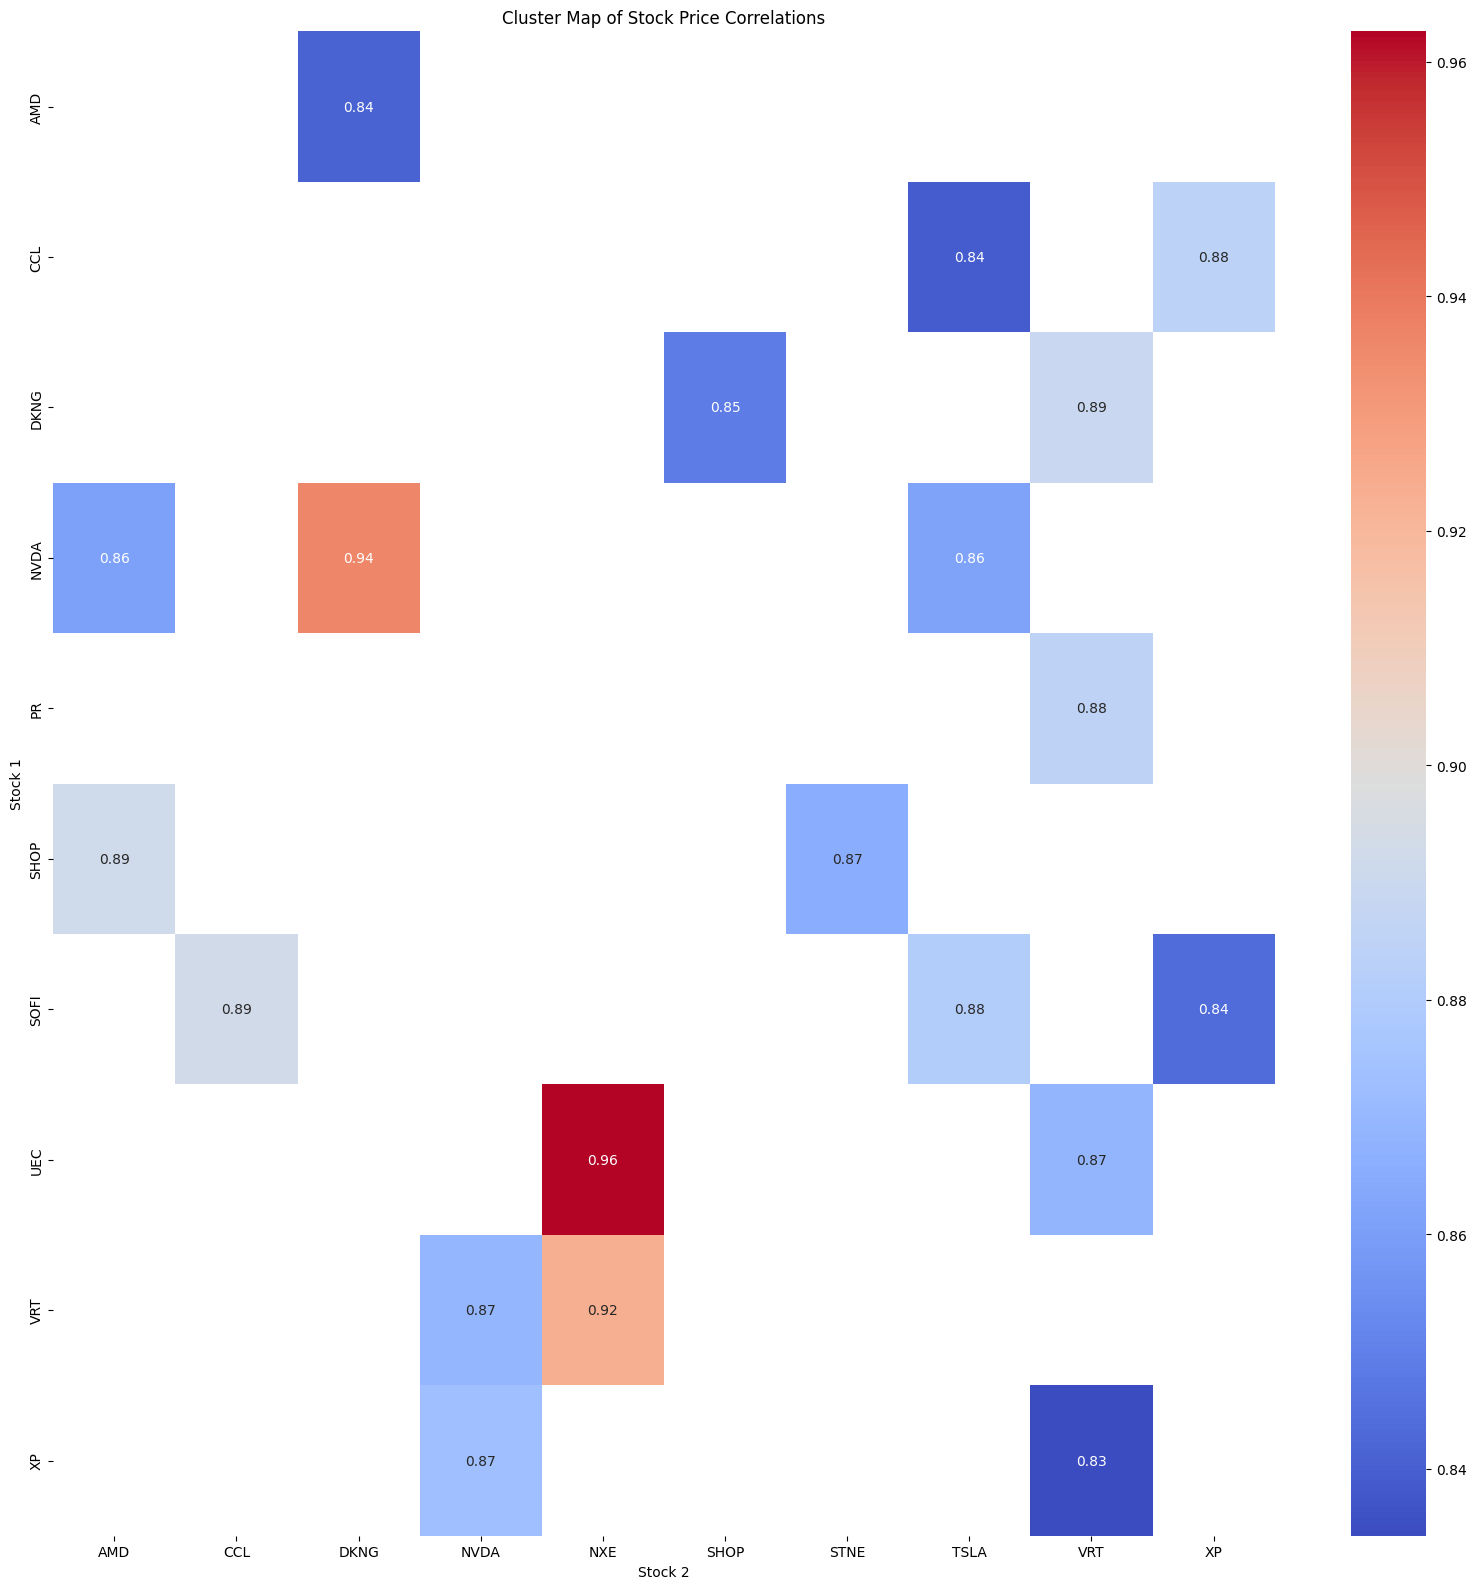

In [26]:
corr_matrix = df_final['Adj Close'].corr()
def get_top_n_correlations(corr_matrix, n):
    c = corr_matrix.abs().stack()
    return c[c < 1].sort_values(ascending=False).drop_duplicates().head(n)

top_n = get_top_n_correlations(corr_matrix, 20)

top_pairs = pd.DataFrame(list(top_n.index), columns=["Stock 1", "Stock 2"])
top_pairs["Correlation"] = top_n.values

top_pairs_pivot = top_pairs.pivot(
    index="Stock 1", columns="Stock 2", values="Correlation"
)

plt.figure(figsize=(16, 16))
sns.heatmap(top_pairs_pivot, annot=True, cmap="coolwarm")
plt.title("Cluster Map of Stock Price Correlations")
# plt.savefig("top_n_heatmap.png")
plt.tight_layout()
plt.show()

In [27]:
returns = df_final['Adj Close'].pct_change()

In [28]:
import plotly.express as px
px.line(returns)

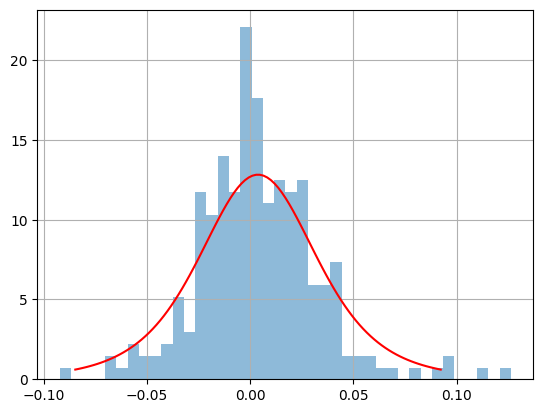

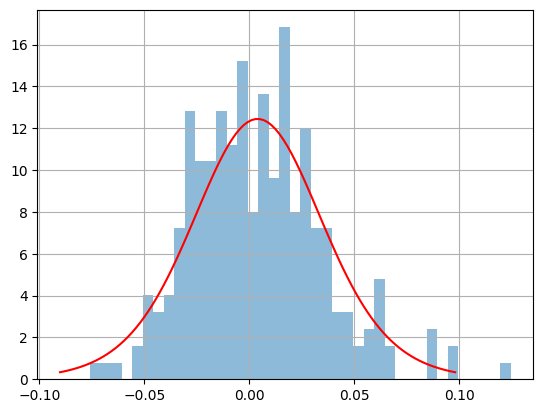

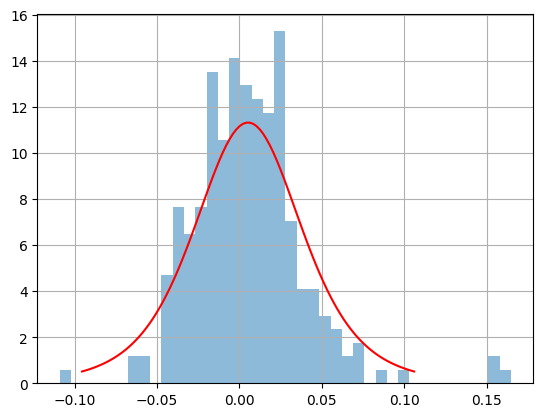

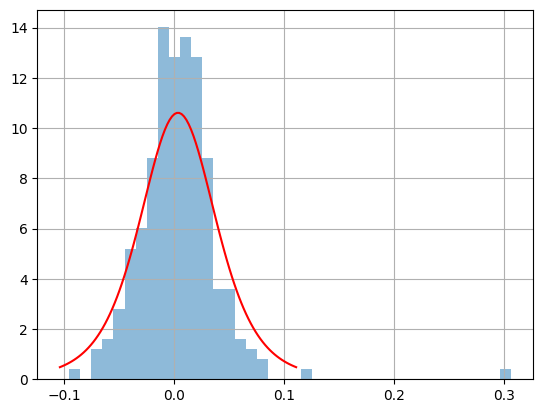

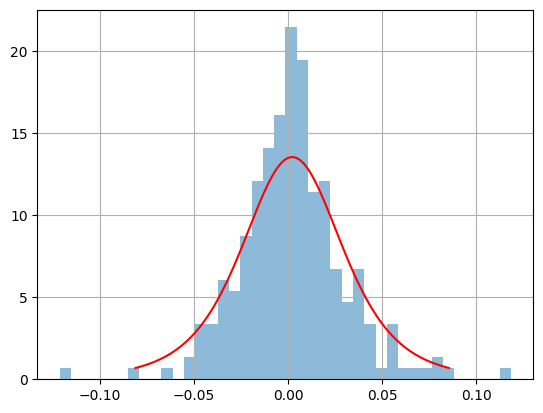

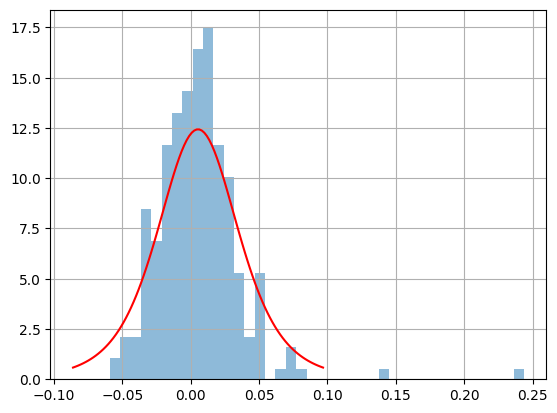

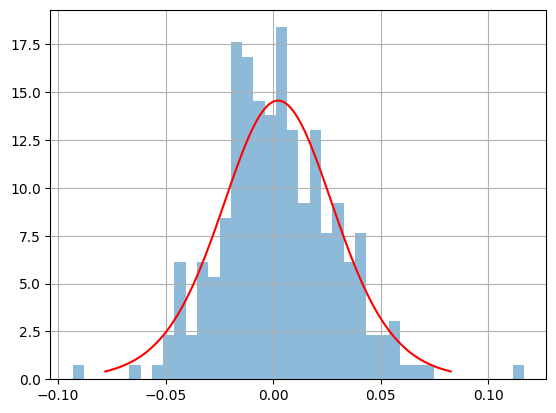

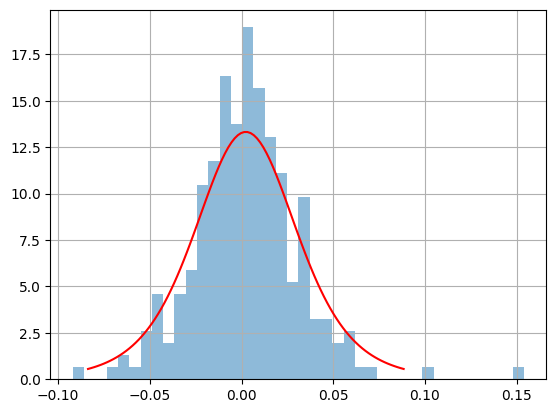

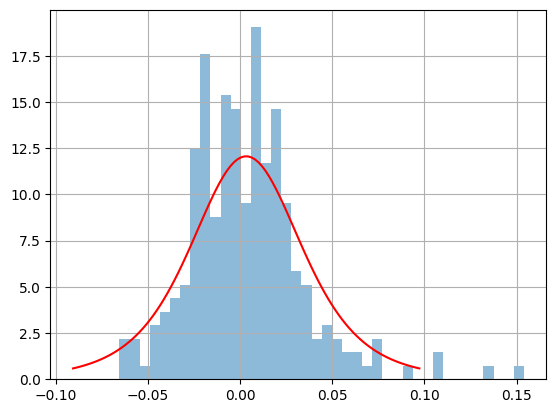

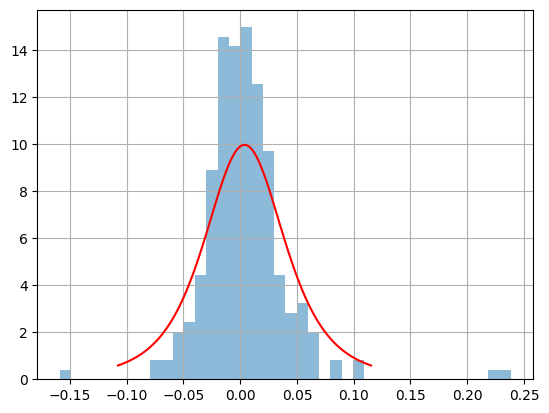

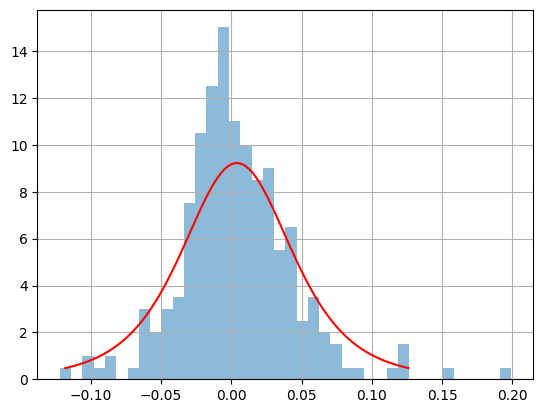

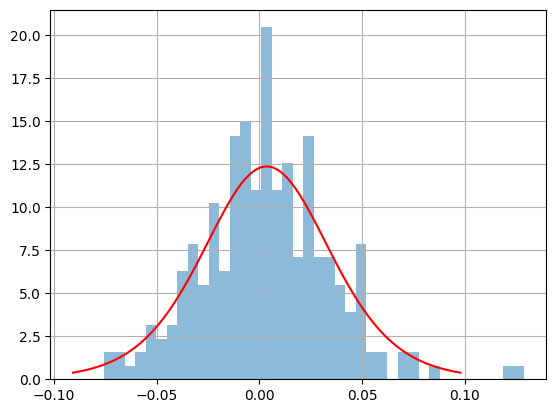

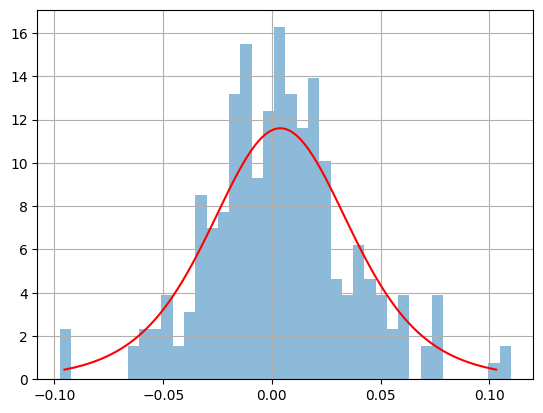

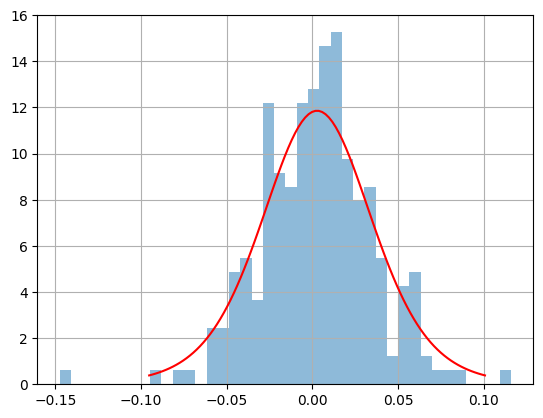

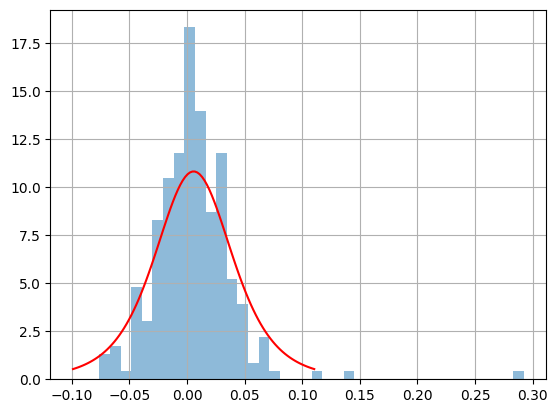

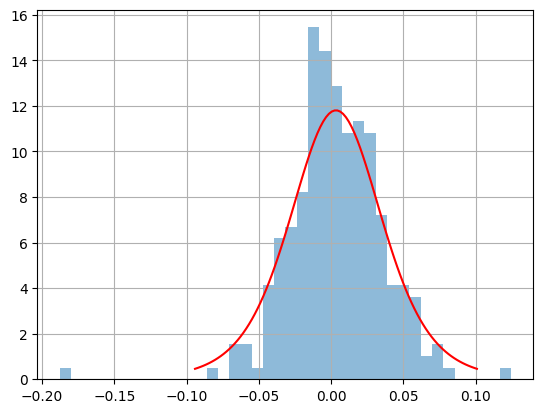

In [30]:
from scipy.stats import norm, t
VaR95 = {}
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(9, 3))
for i, ticker in enumerate(list(returns.columns)):
    df = returns[ticker]
    mean = np.mean(df)
    std_dev = np.std(df)
    # df = (df - mean)/std_dev
    df.hist(bins=40, density=True, histtype='stepfilled', alpha=0.5)
    df, loc, scale = t.fit(returns[ticker].dropna(), loc=0, scale=1)
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
    # axes[i].plot(x, norm.pdf(x, mean, std_dev), "r")
    plt.plot(x, t.pdf(x, df, mean, std_dev), "r")
    plt.show()
    cv = t.ppf(0.05, df, mean, std_dev)
    VaR95[ticker] = -cv

In [31]:
{k: v for k, v in sorted(VaR95.items(), key=lambda item: item[1])}.keys()
stocks_final = {k: v for k, v in sorted(VaR95.items(), key=lambda item: item[1])}.keys()
stocks_final = list(stocks_final)[:10]

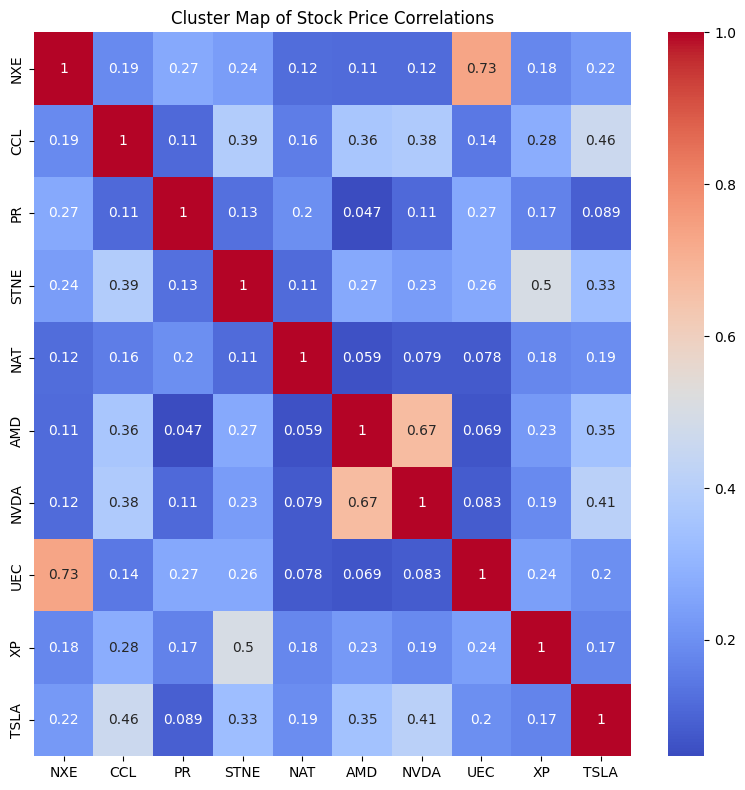

In [33]:
plt.figure(figsize=(8,8))
sns.heatmap(returns[stocks_final].corr(), annot=True, cmap="coolwarm")
plt.title("Cluster Map of Stock Price Correlations")
# plt.savefig("top_n_heatmap.png")
plt.tight_layout()
plt.show()

In [34]:
stocks_final

['NXE', 'CCL', 'PR', 'STNE', 'NAT', 'AMD', 'NVDA', 'UEC', 'XP', 'TSLA']